In [1]:
# importing the dependencies
import keras
import itertools
import tensorflow as tf
from keras import backend as k
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
from IPython.display import clear_output
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import Dense,Flatten,BatchNormalization,Conv2D,MaxPooling2D,Dropout,AveragePooling2D
from sklearn.metrics import confusion_matrix

C:\Users\ADITYA\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [84]:
# reading the data file
data =pd.read_csv('data/data.csv')

In [85]:
# structure of the file
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


This dataset has 7 emotions
(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [86]:
# training data input
X = data['pixels']

In [87]:
# training data target output
y = data['emotion']

In [88]:
# checking the shape of X
print(X.shape)

(35887,)


In [89]:
# checkin the shape of y
print(y.shape)

(35887,)


In [90]:
# splitting individual pixels so that we can feed it into neural network
new_x = []
i = 0

while i<35887:
    k = 0
    insert = [0] * 2304
    val = X[i]
    val = val.split(' ')
    count = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        count = count + insert[k]
        k = k +1
    count = count /(48*48)
    k = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        insert[k] = insert[k] - count
        k = k +1
    
    new_x.append(insert)
    i = i +1
new_x = np.asarray(new_x)
print('Done')

Done


In [91]:
# checking the shape of the new numpy array
print(new_x.shape)

(35887, 2304)


In [92]:
# reshaping the input 
new_x  = np.reshape(new_x, (35887,48,48,1))

In [93]:
# setting X for the sake of consistency
X = new_x

In [74]:
# we will on hot encode y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_y)

In [94]:
# training data
X_train = X[0:28710]
y_train = y[0:28710]

In [76]:
# testing data
X_test = X[28711:35888]
y_test = y[28711:35888]

In [77]:
# checking the shape of the above variables
print (X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28710, 48, 48, 1)
(28710, 7)
(7176, 48, 48, 1)
(7176, 7)


In [78]:
#This will help us to see the learning curve and detect over fitting 
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [79]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [80]:
# plot images with data on jupyter notebook
def plots(ims,figsize=(12,6),rows=1,interp= False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims)%2 ==0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp=f.add_subplot(rows,cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[1], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [189]:
# configuring the image generator
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range= 90, shear_range= .15,
                        zoom_range=.1,
                         horizontal_flip= True,
                         vertical_flip = True
                        )

In [190]:
# this example will show how datagen works 
imagePath = 'cat.jpg'

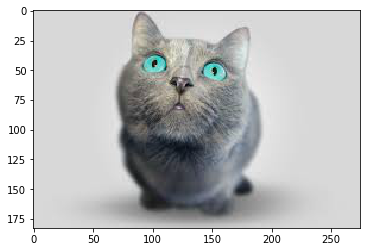

In [191]:
# now get the image
image = np.expand_dims(cv2.imread(imagePath),0)
plt.imshow(image[0])

In [192]:
images = gen.flow(image)

In [193]:
# to get 10 samples of augmened images
aug_images = [next(images)[0].astype(np.uint8) for i in range(10)]

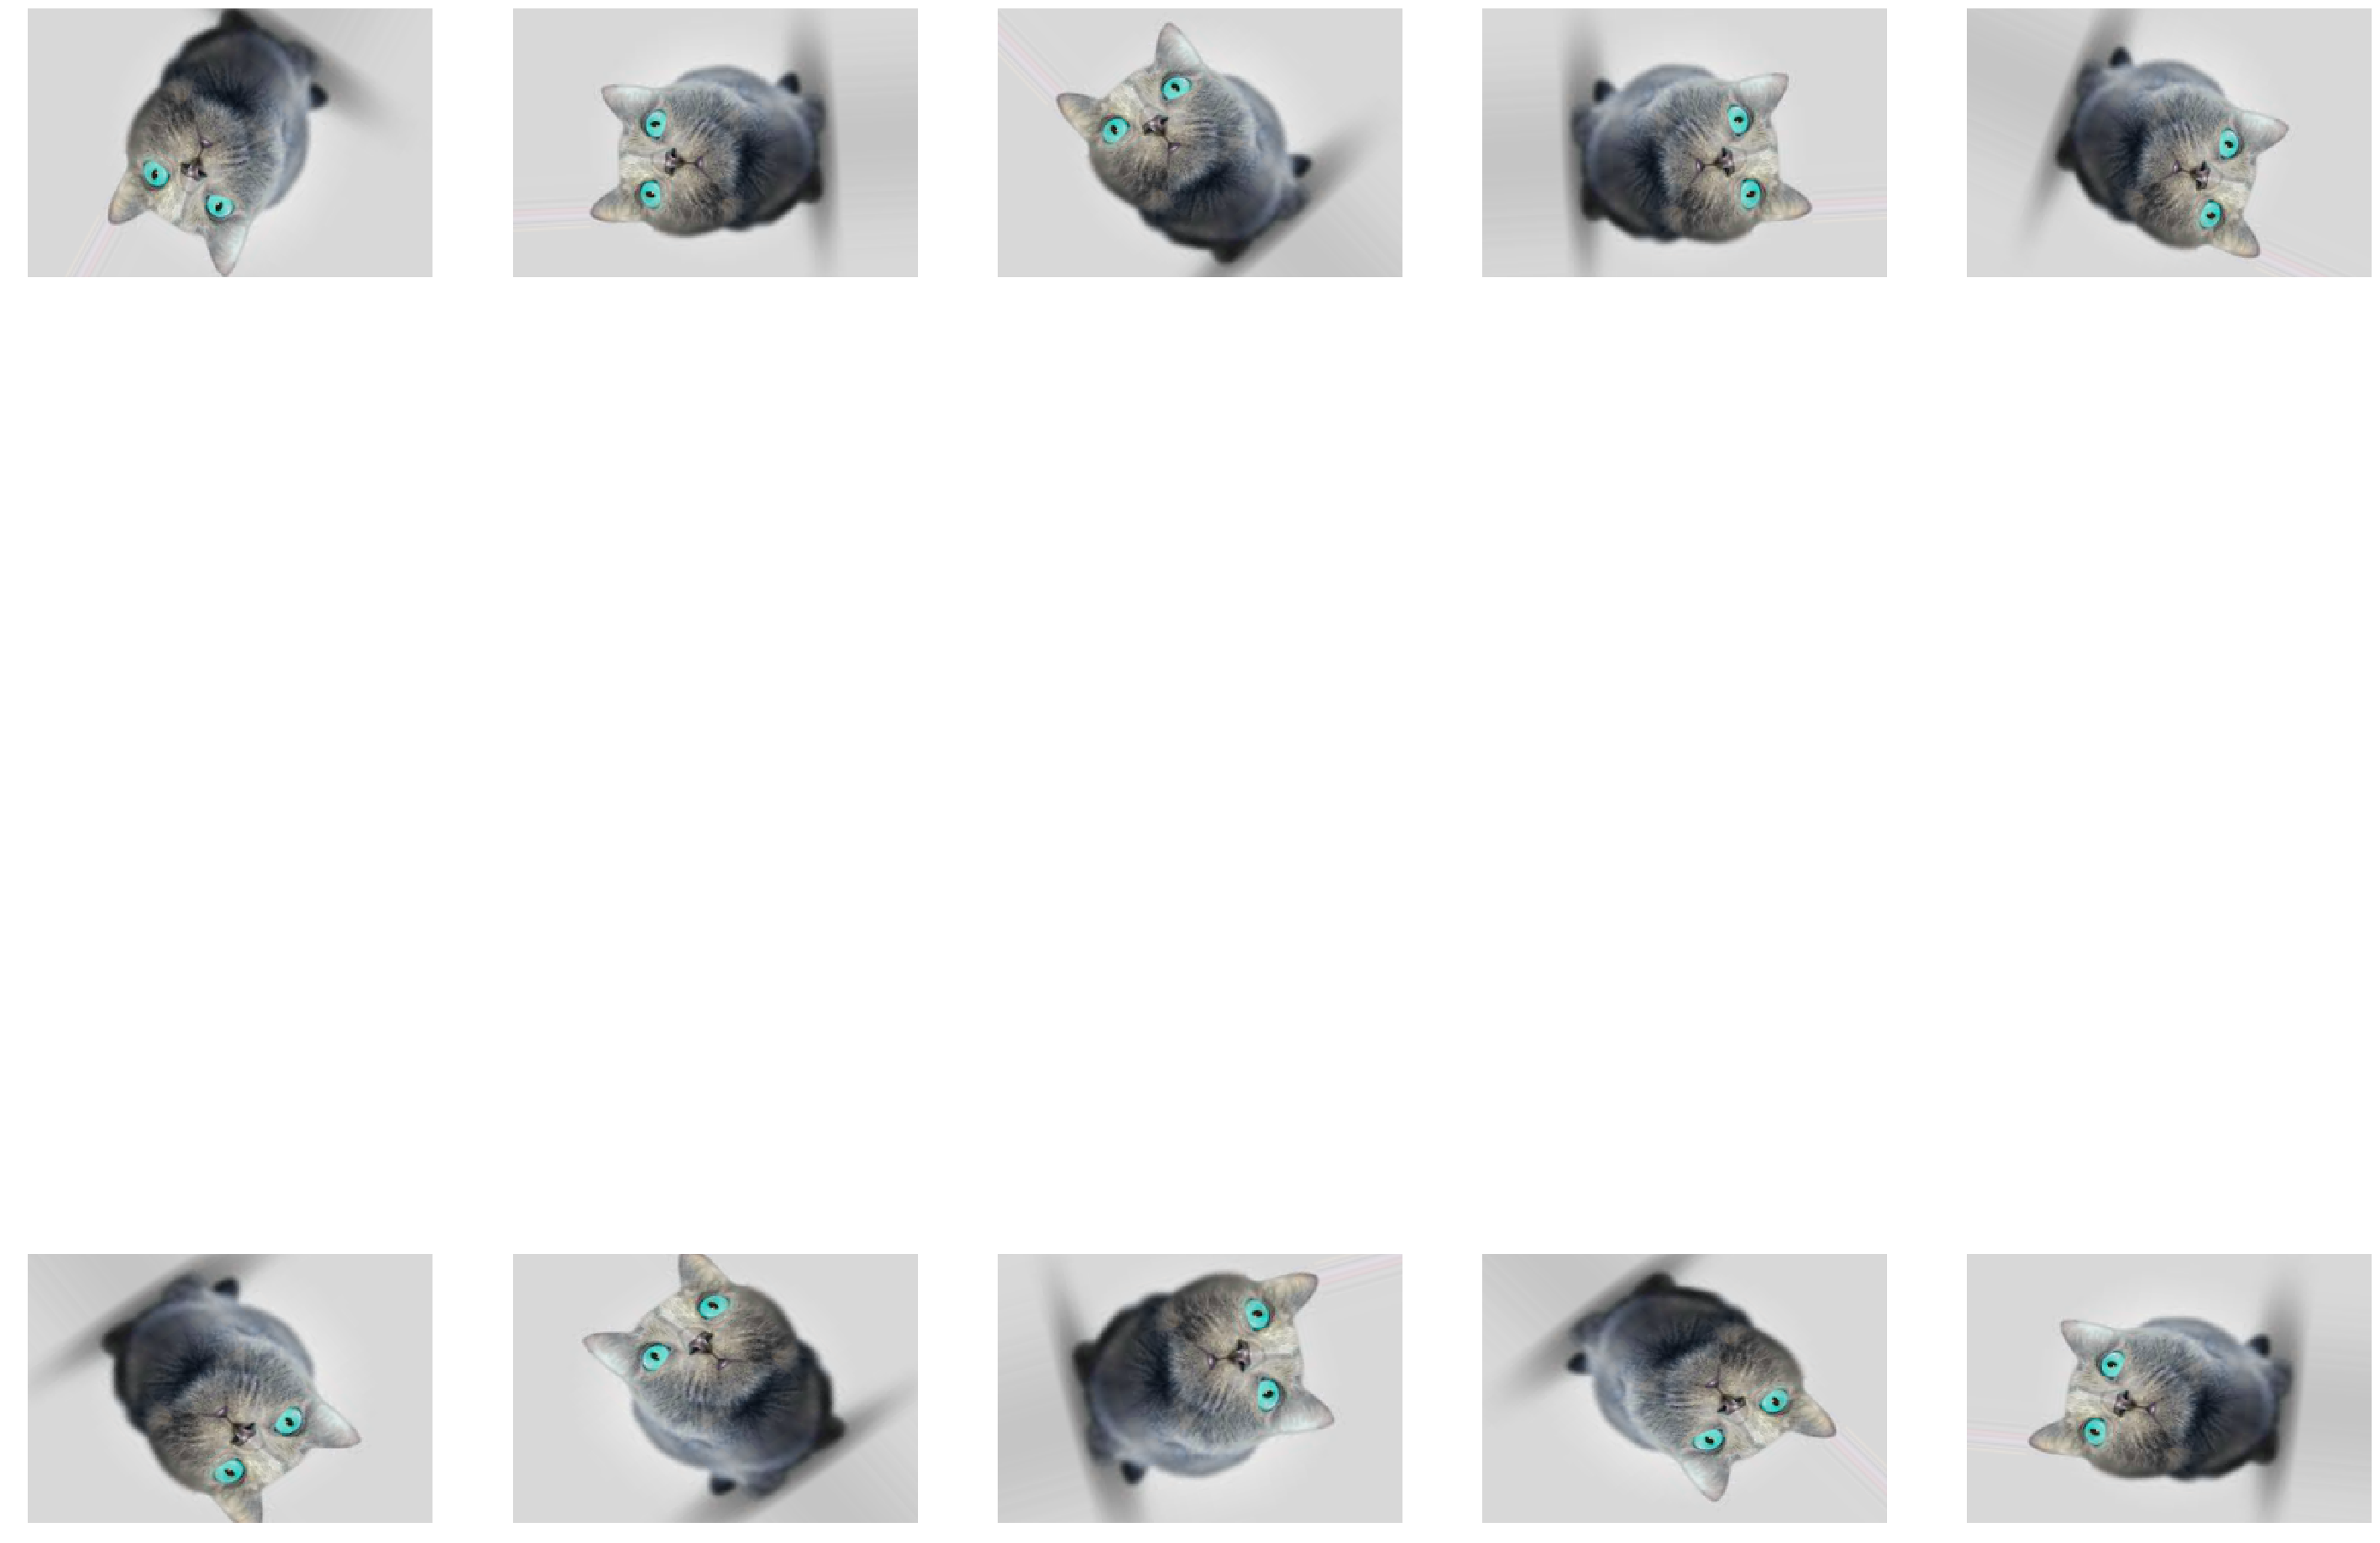

In [194]:
# printing the augmented images 
plots(aug_images, figsize=(50,50), rows=2)

In [81]:
# now we will divide our input into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=0)
# note that we are dividing the training set into training and validation set and do not confuse it with test set

In [196]:
# now we will build a model to learn input patameters
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(128, (2, 2), padding="same", input_shape=(48,48,1), activation="relu"))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(BatchNormalization())


# third convolutional layer with max pooling
model.add(Conv2D(128, (2, 2), padding="same", activation="relu"))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(BatchNormalization())


# third convolutional layer with max pooling
model.add(Conv2D(128, (2,2), padding="same", activation="relu"))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(.5))
model.add(BatchNormalization())

          
model.add(Flatten())
model.add(Dropout(.5))
# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(7, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [197]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 48, 48, 128)       640       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 128)       65664     
_________________________________________________________________
average_pooling2d_11 (Averag (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 12, 12, 128)       0         
__________

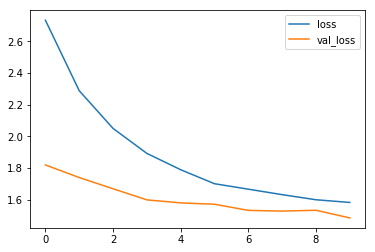

In [198]:
# fitting the model without data augmentation
model.fit(X_train, y_train,
          validation_data=[X_test,y_test],
          callbacks = [plot_losses],
          batch_size=1000, 
          epochs=10, 
          verbose=1)



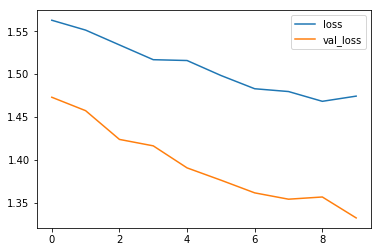

In [199]:
# fitting the model without data augmentation
model.fit(X_train, y_train,
          validation_data=[X_test,y_test],
          callbacks = [plot_losses],
          batch_size=1000, 
          epochs=10, 
          verbose=1)

In [39]:
model.save('model.h5')

In [21]:
from keras.models import load_model
model = load_model('model.h5')

In [49]:
y_pred = model.predict(X_test,verbose = 1)

5742/5742 [==============================] - 82s 14ms/step


In [50]:
y_pred = (np.argmax(y_pred,axis = 1))

In [51]:
y_test = (np.argmax(y_test,axis = 1))

Confusion matrix, without normalization
[[ 314    0   37  131  139   36  162]
 [  15   19   10   16   13    4    5]
 [  85    0  158  109  196  121  151]
 [  37    0    9 1217   75   30   76]
 [  75    0   48  111  453   17  236]
 [  17    1   35   63   26  460   64]
 [  42    0   17  167  143   20  582]]
Normalized confusion matrix
[[0.38 0.   0.05 0.16 0.17 0.04 0.2 ]
 [0.18 0.23 0.12 0.2  0.16 0.05 0.06]
 [0.1  0.   0.19 0.13 0.24 0.15 0.18]
 [0.03 0.   0.01 0.84 0.05 0.02 0.05]
 [0.08 0.   0.05 0.12 0.48 0.02 0.25]
 [0.03 0.   0.05 0.09 0.04 0.69 0.1 ]
 [0.04 0.   0.02 0.17 0.15 0.02 0.6 ]]


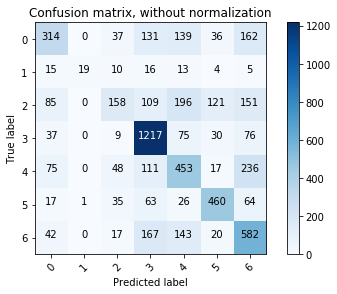

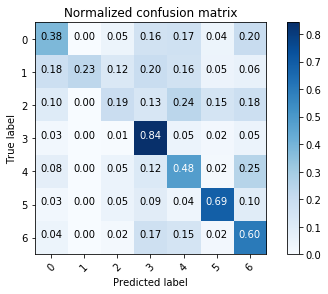

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [53]:
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(encoded_y)

In [54]:
y_test.shape

(5742, 7)

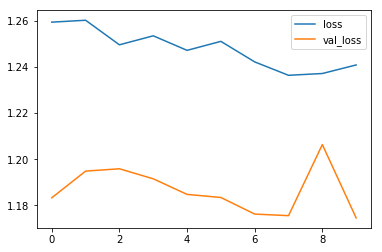

In [38]:
checkpoint = keras.callbacks.ModelCheckpoint('model_new.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# fitting the model without data augmentation
model.fit(X_train, y_train,
          validation_data=[X_test,y_test],
          callbacks = [plot_losses, checkpoint],
          batch_size=1000, 
          epochs=10, 
          verbose=1)

In [40]:
# to check how we scored on the public and private leaderboard
# outputs are given on the data file 


# reading the data file
data =pd.read_csv('data/data.csv')
# training data input
X = data['pixels']
# training data target output
y = data['emotion']
# testing data
y_test_lb = y[28711:35888]

In [41]:
new_x = []
i = 28711

while i<35887:
    k = 0
    insert = [0] * 2304
    val = X[i]
    val = val.split(' ')
    count = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        count = count + insert[k]
        k = k +1
    count = count /(48*48)
    k = 0
    while k<2304:
        insert[k] = (int)(val[k])
        # to make input between 0 and 1
        insert[k] = insert[k] - count
        k = k +1
    
    new_x.append(insert)
    i = i +1
new_x = np.asarray(new_x)
print('Done')

Done


In [42]:
X_test_lb = new_x
print(X_test_lb.size)

16533504


In [43]:
# forming the leaderboard test input
X_test_lb = np.reshape(X_test_lb , (7176,48,48,1))

In [44]:
# getting the input
output = model.predict(X_test_lb, verbose = 1,batch_size = 100)

7176/7176 [==============================] - 102s 14ms/step


In [45]:
print(output)
output = np.argmax(output, axis = 1)

[[4.3246871e-01 2.6454257e-02 1.6033071e-01 ... 2.4621662e-01
  1.8536728e-02 1.0972535e-01]
 [1.9122232e-01 3.4894802e-02 1.6733059e-01 ... 3.8867182e-01
  9.6107787e-03 1.7715561e-01]
 [2.0368744e-03 3.9101290e-04 6.1850448e-04 ... 1.5528661e-03
  3.3923163e-04 2.9644205e-03]
 ...
 [7.3785789e-02 1.3280533e-03 3.6582749e-02 ... 2.1109626e-01
  6.1350469e-02 5.7011873e-01]
 [9.8814599e-02 9.4786589e-04 4.8871404e-03 ... 7.0583232e-02
  9.9459337e-04 2.6630163e-02]
 [1.4534257e-01 2.6248455e-02 1.3414545e-01 ... 4.0415770e-01
  1.7015215e-02 2.4990413e-01]]


In [46]:
print(output[0])

0


In [47]:
# checking how many predictions we have made correct
i = 0
count = 0
while i<7176:
    if output[i] == y_test_lb[i+28711]:
        count = count + 1
    else:
        count = count + 0
    i = i +1 

count = count /7176

In [48]:
# printing the percentage of correctly identifies examples
print(count)

0.56061872909699


Confusion matrix, without normalization
[[ 363    4   42  156  166   48  178]
 [  34   29    4   14   16    5    8]
 [ 109    1  177  126  243  164  204]
 [  37    1   19 1523   79   41   74]
 [ 109    2   62  162  589   21  302]
 [  25    1   46   80   22  587   70]
 [  60    1   31  181  181   24  755]]
Normalized confusion matrix
[[3.79e-01 4.18e-03 4.39e-02 1.63e-01 1.73e-01 5.02e-02 1.86e-01]
 [3.09e-01 2.64e-01 3.64e-02 1.27e-01 1.45e-01 4.55e-02 7.27e-02]
 [1.06e-01 9.77e-04 1.73e-01 1.23e-01 2.37e-01 1.60e-01 1.99e-01]
 [2.09e-02 5.64e-04 1.07e-02 8.59e-01 4.45e-02 2.31e-02 4.17e-02]
 [8.74e-02 1.60e-03 4.97e-02 1.30e-01 4.72e-01 1.68e-02 2.42e-01]
 [3.01e-02 1.20e-03 5.54e-02 9.63e-02 2.65e-02 7.06e-01 8.42e-02]
 [4.87e-02 8.11e-04 2.51e-02 1.47e-01 1.47e-01 1.95e-02 6.12e-01]]


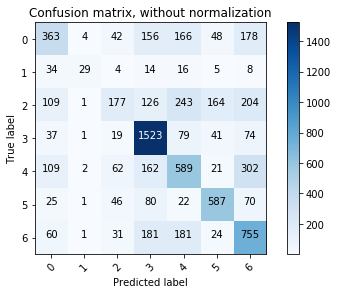

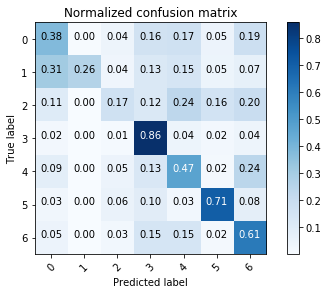

In [55]:
# plotting the confusion matrix (leader board data)
cnf_matrix = confusion_matrix(y_test_lb, output)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2','3','4','5','6'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


we are performing good classes 3 4 5 6 but are peforming very bad on classes 0 1 2 

In [56]:
# total no of examples 1.e in the training set and test set

data =pd.read_csv('data/data.csv')
# training data target output
y = data['emotion']
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
i = 0
while i<28710:
    num = y[i]
    if num == 0:
        count_0 = count_0 + 1
    elif num == 1:
        count_1 = count_1 +1
    elif num == 1:
        count_1 = count_1 +1
    
    elif num == 2:
        count_2 = count_2 +1
    
    elif num == 3:
        count_3 = count_3 +1
    
    elif num == 4:
        count_4 = count_4 +1
    
    elif num == 5:
        count_5 = count_5 +1
    
    elif num == 6:
        count_6 = count_6 +1
    
    i = i +1

In [60]:
# printing the output

print('class 0: ',count_0)
print('class 1: ',count_1)
print('class 2: ',count_2)
print('class 3: ',count_3)
print('class 4: ',count_4)
print('class 5: ',count_5)
print('class 6: ',count_6)

class 0:  3996
class 1:  436
class 2:  4097
class 3:  7215
class 4:  4830
class 5:  3171
class 6:  4965


In [62]:
# no of examples in the test_lb set
data =pd.read_csv('data/data.csv')
# training data target output
y = data['emotion']
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
i = 28711
while i<35887:
    num = y[i]
    if num == 0:
        count_0 = count_0 + 1
    elif num == 1:
        count_1 = count_1 +1
    elif num == 1:
        count_1 = count_1 +1
    
    elif num == 2:
        count_2 = count_2 +1
    
    elif num == 3:
        count_3 = count_3 +1
    
    elif num == 4:
        count_4 = count_4 +1
    
    elif num == 5:
        count_5 = count_5 +1
    
    elif num == 6:
        count_6 = count_6 +1
    
    i = i +1

In [63]:
# printing the output
print('class 0: ',count_0)
print('class 1: ',count_1)
print('class 2: ',count_2)
print('class 3: ',count_3)
print('class 4: ',count_4)
print('class 5: ',count_5)
print('class 6: ',count_6)

class 0:  957
class 1:  110
class 2:  1024
class 3:  1774
class 4:  1247
class 5:  831
class 6:  1233


In [106]:
# checking the no of examples in the cross validation set
#y_test = np.argmax(y_test, axis = 1)
print(y_test.shape)


(5742,)


In [107]:
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
i = 0
while i<5742:
    num = y_test[i]
    if num == 0:
        count_0 = count_0 + 1
    elif num == 1:
        count_1 = count_1 +1
    elif num == 1:
        count_1 = count_1 +1
    
    elif num == 2:
        count_2 = count_2 +1
    
    elif num == 3:
        count_3 = count_3 +1
    
    elif num == 4:
        count_4 = count_4 +1
    
    elif num == 5:
        count_5 = count_5 +1
    
    elif num == 6:
        count_6 = count_6 +1
    
    i = i +1

In [108]:
# printing the output
print('class 0: ',count_0)
print('class 1: ',count_1)
print('class 2: ',count_2)
print('class 3: ',count_3)
print('class 4: ',count_4)
print('class 5: ',count_5)
print('class 6: ',count_6)

class 0:  819
class 1:  82
class 2:  820
class 3:  1444
class 4:  940
class 5:  666
class 6:  971
